In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import copy

In [3]:
def show_images(image_dict, height=6):
    image_num = len(image_dict)
    width = np.ceil(height * 4 / 3) * image_num
    plt.figure(figsize=(width, height))
    for i in range(image_num):
        plt.subplot(1, image_num, i + 1)
        key = list(image_dict.keys())[i]
        plt.title(key)
        plt.imshow(image_dict[key], cmap='gray')

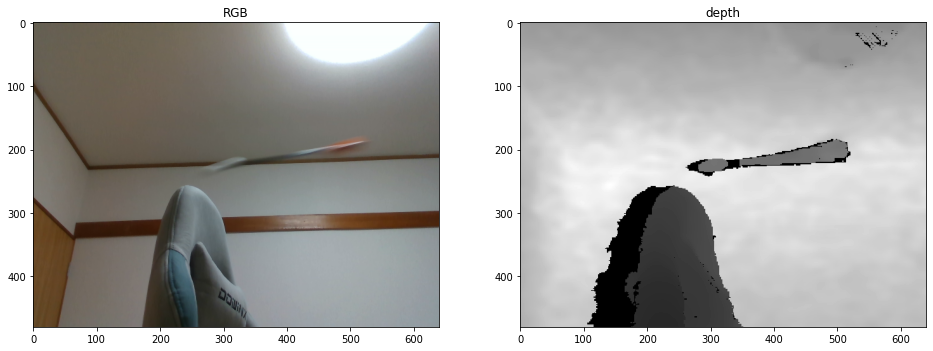

In [4]:
image_color = cv2.imread('images/flying_arrow/color/color16083310207799372.png')
image_depth = cv2.imread('images/flying_arrow/depth/depth16083310207799372.png', cv2.IMREAD_ANYDEPTH)

image_color_RGB = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
show_images({'RGB': image_color_RGB, 'depth': image_depth})

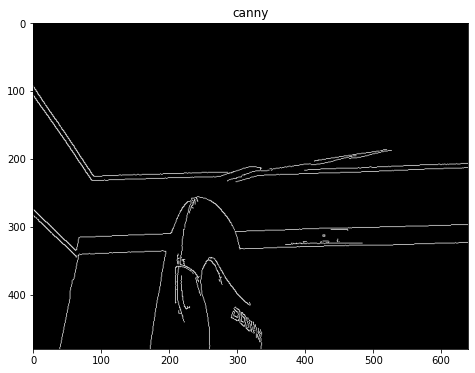

In [5]:
image_color_copy = copy.deepcopy(image_color_RGB)
gray = cv2.cvtColor(image_color_copy, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

show_images({'canny': edges})

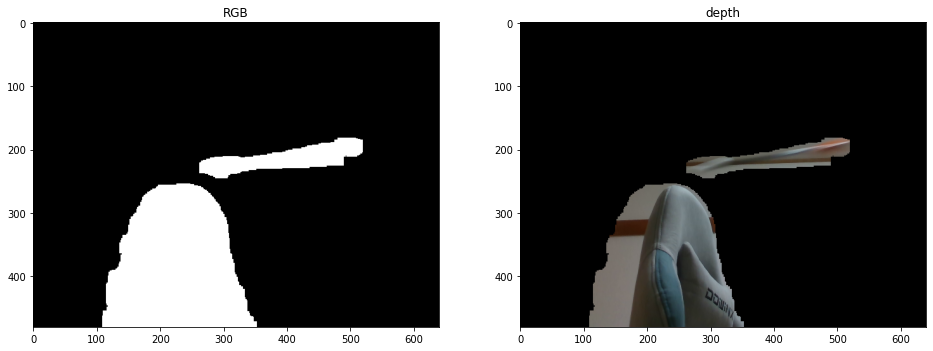

In [7]:
ret, sure_bg = cv2.threshold(image_depth, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((5, 5), np.uint8)
sure_bg = cv2.morphologyEx(sure_bg, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(sure_bg, kernel, iterations=2)
sure_bg = np.uint8(sure_bg)

sure_bg_RGB = cv2.cvtColor(sure_bg, cv2.COLOR_GRAY2RGB)
image_color_forground = cv2.bitwise_and(image_color_RGB, sure_bg_RGB)

show_images({'RGB': sure_bg, 'depth': image_color_forground})

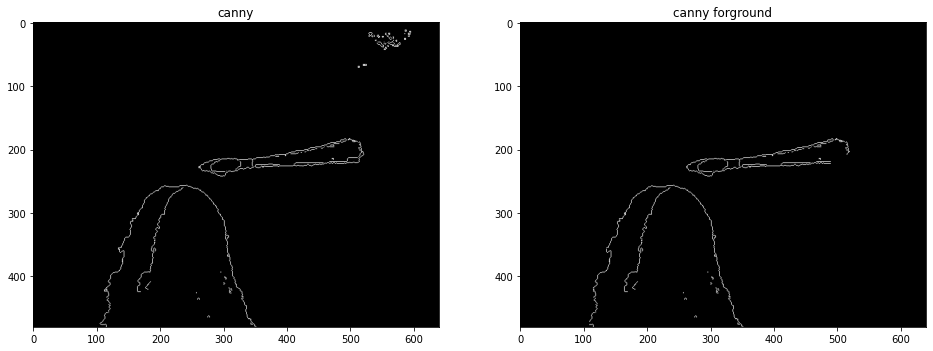

In [18]:
image_depth_uint8 = cv2.convertScaleAbs(image_depth, alpha=(255 / np.max(image_depth)))
edges = cv2.Canny(image_depth_uint8, 300, 200, apertureSize=3)
edges_forground = cv2.bitwise_and(edges, sure_bg)

show_images({'canny': edges, 'canny forground': edges_forground})

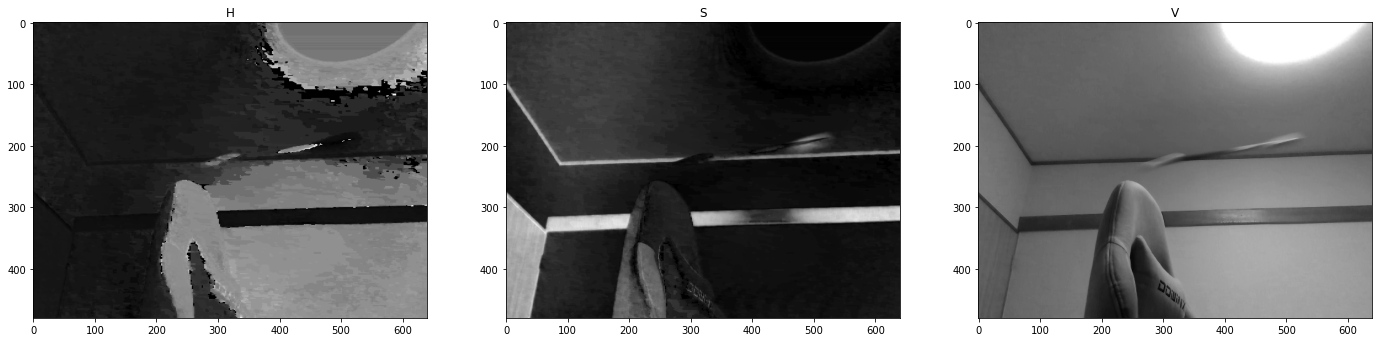

In [42]:
image_hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

show_images({'H': image_hsv[:, :, 0], 'S': image_hsv[:, :, 1], 'V': image_hsv[:, :, 2]})

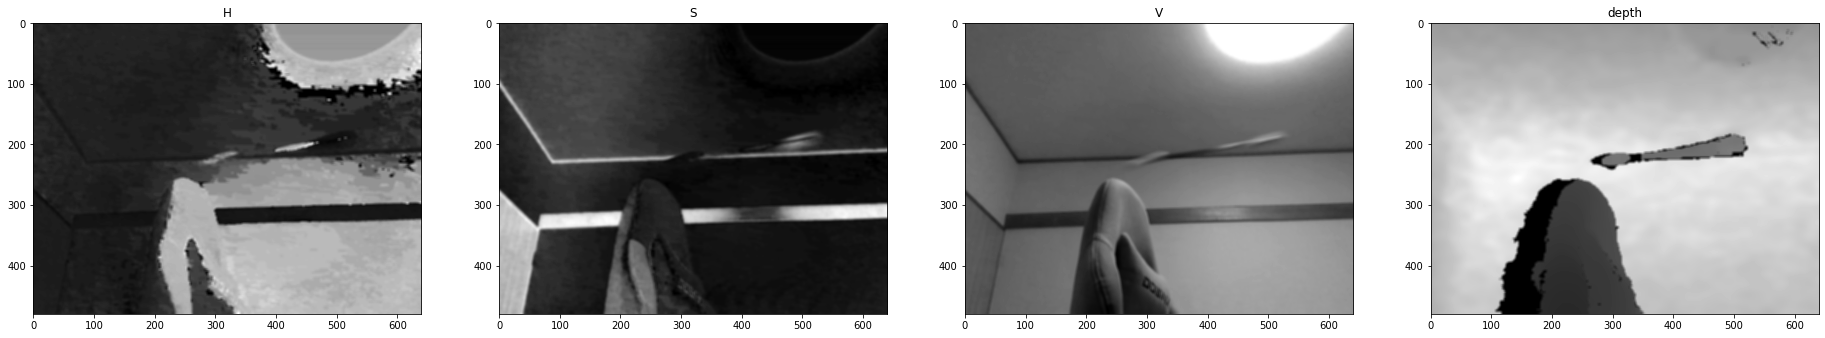

In [43]:
blur_hsv = cv2.blur(image_hsv, (5, 5))
blur_depth = cv2.blur(image_depth, (5, 5))

show_images({'H': blur_hsv[:, :, 0], 'S': blur_hsv[:, :, 1], 'V': blur_hsv[:, :, 2], 'depth': blur_depth})

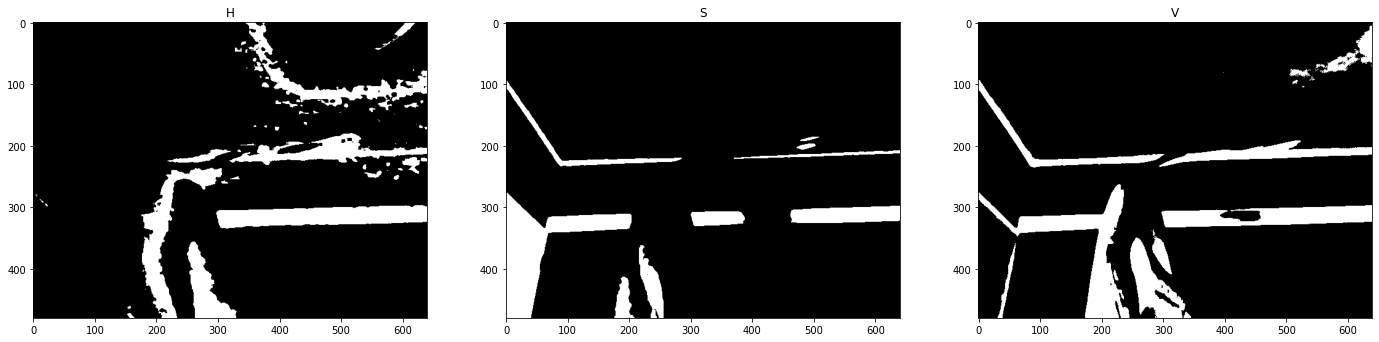

In [44]:
thresh_H = cv2.adaptiveThreshold(blur_hsv[:, :, 0], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 151, 9)
ret, thresh_S = cv2.threshold(blur_hsv[:, :, 1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh_V = cv2.adaptiveThreshold(blur_hsv[:, :, 2], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 151, 9)

show_images({'H': thresh_H, 'S': thresh_S, 'V': thresh_V})

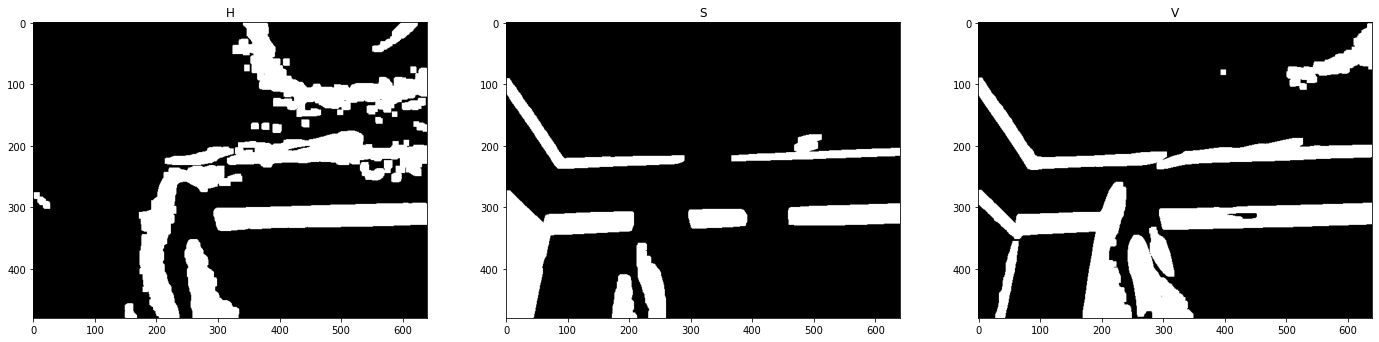

In [45]:
kernel = np.ones((5, 5), np.uint8)
thresh_dilation_H = cv2.dilate(thresh_H, kernel, iterations=2)
thresh_dilation_S = cv2.dilate(thresh_S, kernel, iterations=2)
thresh_dilation_V = cv2.dilate(thresh_V, kernel, iterations=2)

show_images({'H': thresh_dilation_H, 'S': thresh_dilation_S, 'V': thresh_dilation_V})

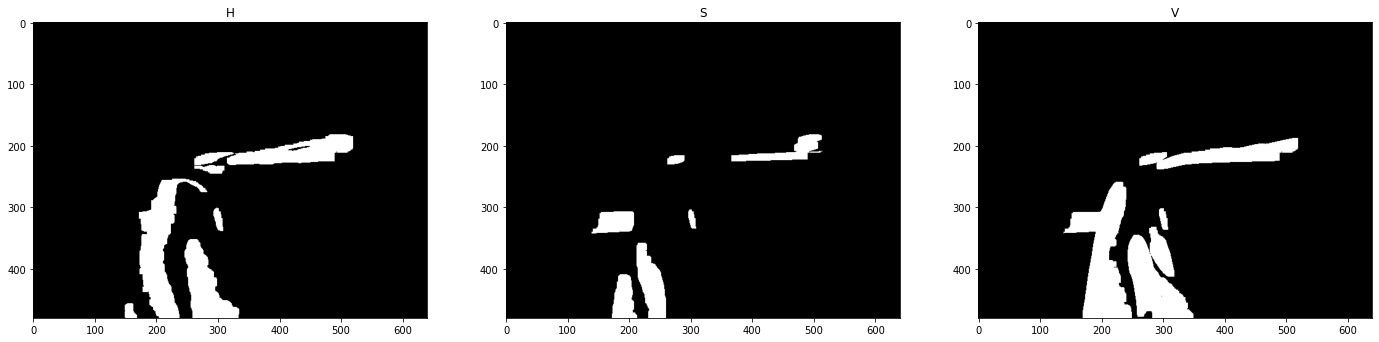

In [46]:
thresh_forground_H = cv2.bitwise_and(thresh_dilation_H, sure_bg)
thresh_forground_S = cv2.bitwise_and(thresh_dilation_S, sure_bg)
thresh_forground_V = cv2.bitwise_and(thresh_dilation_V, sure_bg)

show_images({'H': thresh_forground_H, 'S': thresh_forground_S, 'V': thresh_forground_V})

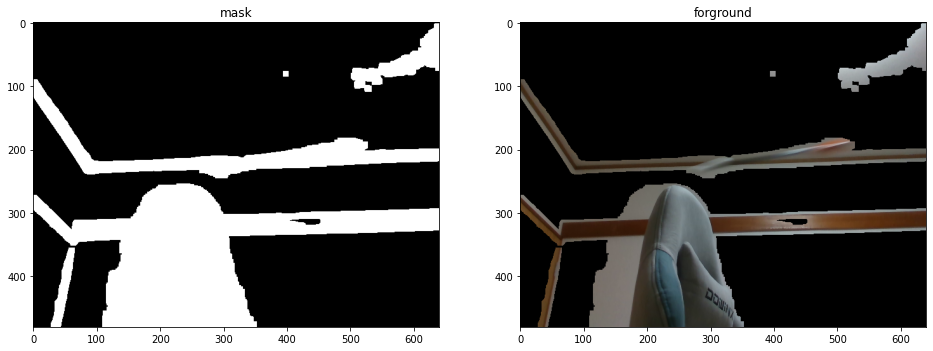

In [47]:
mask = cv2.bitwise_or(sure_bg, thresh_dilation_V)
mask_RGB = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
image_color_forground = cv2.bitwise_and(image_color_RGB, mask_RGB)

show_images({'mask': mask, 'forground': image_color_forground})

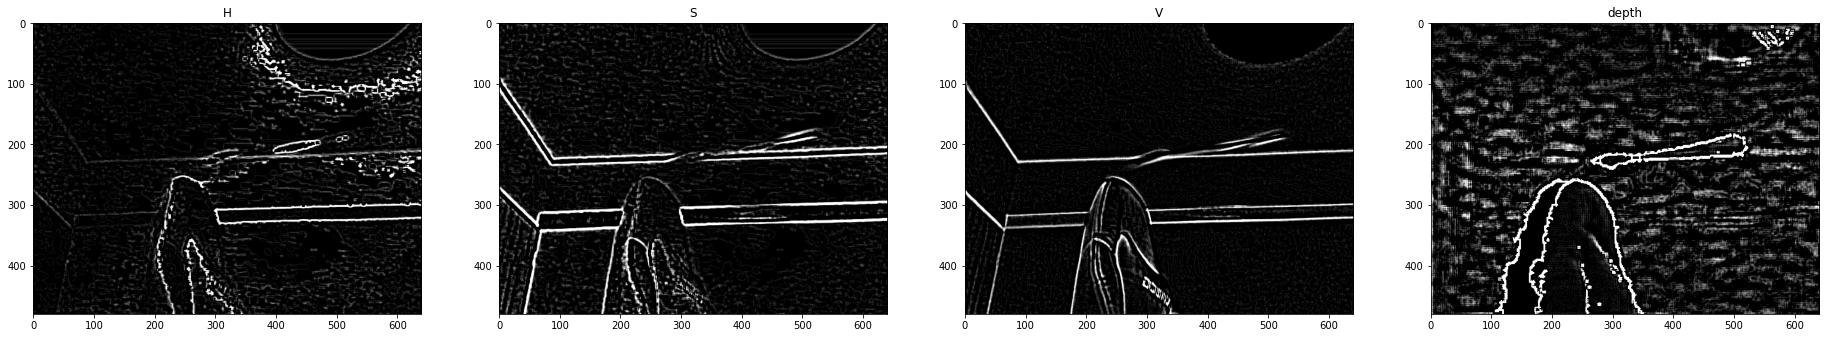

In [48]:
laplacian_hsv = cv2.Laplacian(blur_hsv, ddepth=cv2.CV_8U, ksize=5)
laplacian_depth = cv2.Laplacian(blur_depth, ddepth=cv2.CV_8U, ksize=5)

show_images({'H': laplacian_hsv[:, :, 0], 'S': laplacian_hsv[:, :, 1], 'V': laplacian_hsv[:, :, 2], 'depth': laplacian_depth})

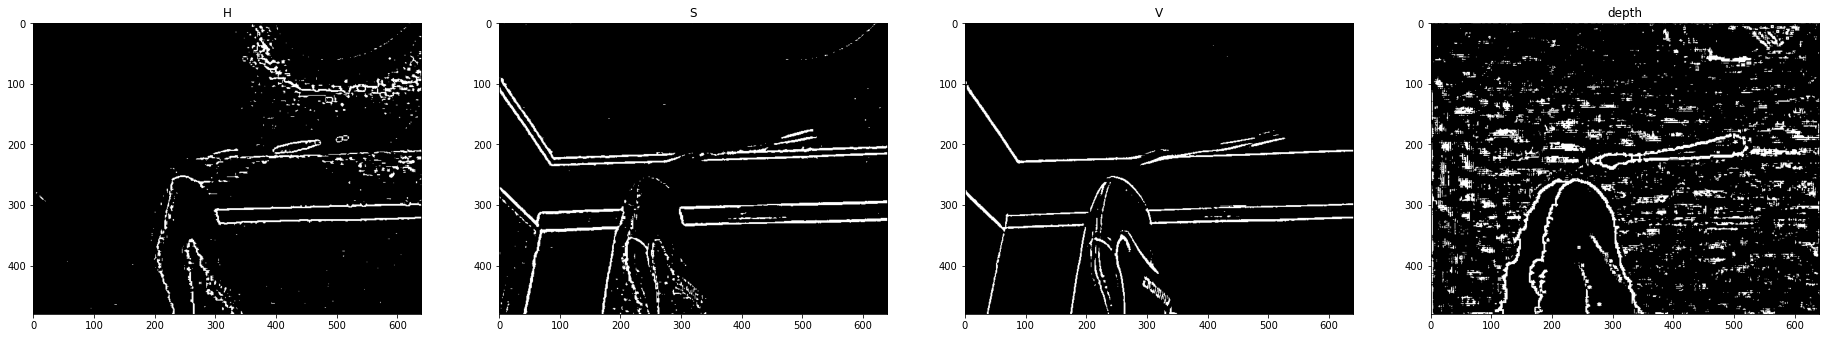

In [49]:
ret, laplacian_thresh_H = cv2.threshold(laplacian_hsv[:, :, 0], 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, laplacian_thresh_S = cv2.threshold(laplacian_hsv[:, :, 1], 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, laplacian_thresh_V = cv2.threshold(laplacian_hsv[:, :, 2], 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, laplacian_thresh_depth = cv2.threshold(laplacian_depth, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show_images({'H': laplacian_thresh_H, 'S': laplacian_thresh_S, 'V': laplacian_thresh_V, 'depth': laplacian_thresh_depth})

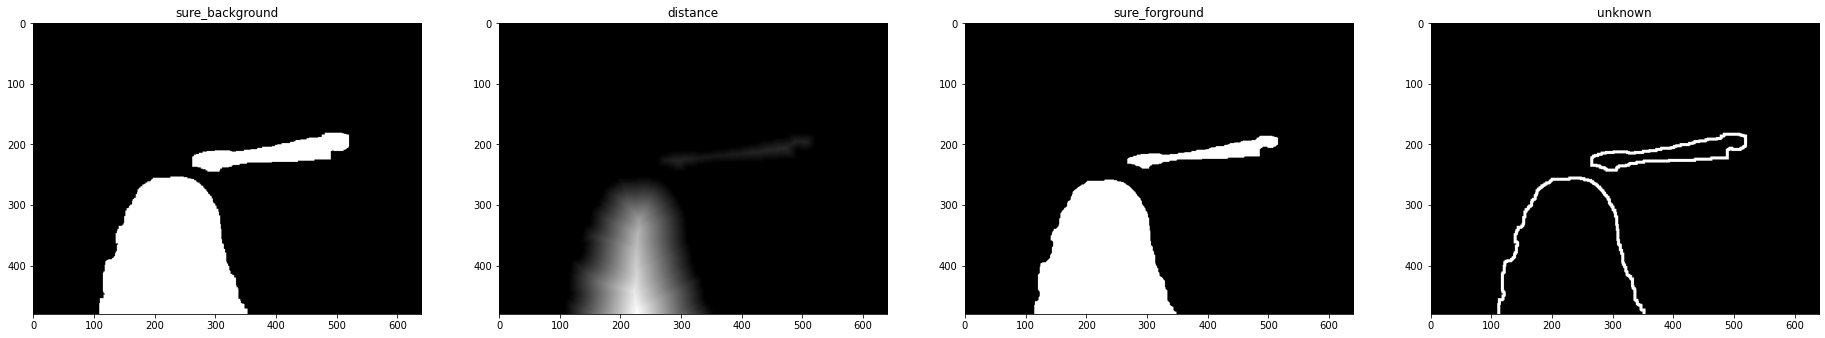

In [50]:
sure_bg_line = cv2.bitwise_and(laplacian_thresh_depth, sure_bg)
sure_bg_line = sure_bg
dist_transform = cv2.distanceTransform(sure_bg_line, cv2.DIST_L2, 5)
dist_transform = cv2.distanceTransform(sure_bg_line, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.05 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

show_images({'sure_background': sure_bg_line, 'distance': dist_transform, 'sure_forground': sure_fg, 'unknown': unknown})

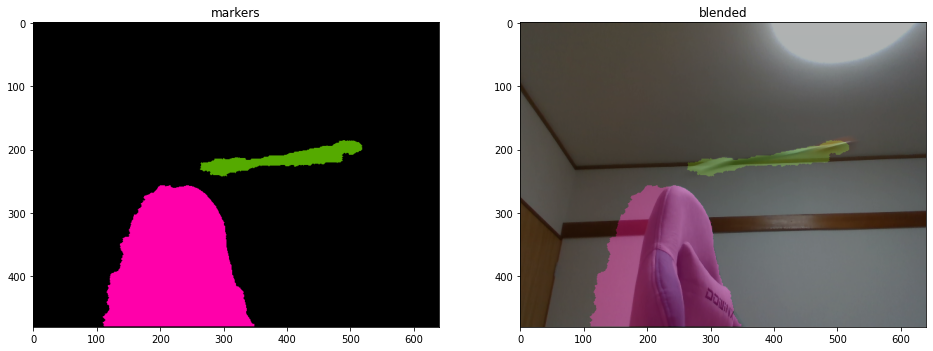

In [51]:
# Marker labelling
ret, markers_unknown = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers_unknown = markers_unknown + 1

# Now, mark the region of unknown with zero
markers_unknown[unknown==255] = 0

markers = cv2.watershed(image_color, markers_unknown)

# show data
def marker2colormap(markers):
    markers_color = cv2.convertScaleAbs(markers, alpha=(255 / np.max(markers)))
    markers_color = cv2.applyColorMap(markers_color, cv2.COLORMAP_RAINBOW)
    markers_color[markers == -1] = [0, 0, 0]
    markers_color[markers == 1] = [0, 0, 0]
    return markers_color

markers_unknown_color = marker2colormap(markers_unknown)
markers_color = marker2colormap(markers)

blended = cv2.addWeighted(
    src1=image_color_RGB,
    alpha=0.7,
    src2=markers_color,
    beta=0.3,
    gamma=0)

show_images({'markers': markers_color, 'blended': blended})

3


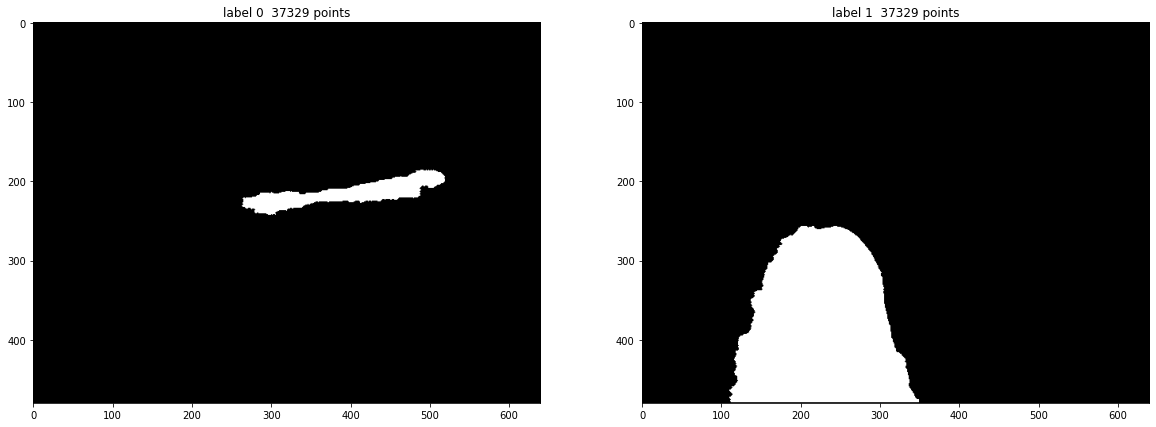

In [54]:
plt.figure(figsize=(20, 20))
markers[markers == -1] = 0
label_num = np.max(markers)
print(label_num)
mask_list = []
for i in range(2, label_num + 1):
    mask = copy.deepcopy(markers)
    mask = np.uint8(mask)
    mask[markers != i] = 0
    mask[markers == i] = 1

    mask_copy = copy.deepcopy(mask)
    mask_copy[image_depth == 0] = 0
    point_num = np.sum(mask_copy)
    if point_num > 500: mask_list.append(mask)

rowcol = np.ceil(np.sqrt(len(mask_list)))
for i in range(len(mask_list)):
    plt.subplot(rowcol, rowcol, i + 1)
    plt.title('label {}  {} points'.format(i, np.sum(mask)))
    plt.imshow(mask_list[i], cmap='gray')